In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.2.204:34629")
client

Client Scheduler: tcp://10.32.2.204:34629 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 26 Cores: 52 Memory: 299.00 GB


# Cumulative volume time derivative ($\frac{\partial \mathcal{V}}{\partial t}$) in T Space
ECCO

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [4]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
#rename time (and iter axis)
dt = dt.rename({'time_snp':'time'})
# time axis of dt should be the same as of the monthly averages
dt.time.values = ds.time[1:-1].values
#dt.time.values = ds.time.values[1:-1] 
#add nans to dt to change size form 286 to 288

ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

#should I just add nans as first and last value?

In [5]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])

In [6]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ETAN       (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    ETAN_snp   (time_snp, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    GEOFLX     (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    SALT       (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    SALT_snp   (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    SFLUX      (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    TFLUX      (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    THETA      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    THETA_snp  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    WVELMASS   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    oceFWflx   (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceQsw     (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceSPtnd   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    ADVx_TH    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    DFxE_SLT   (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFyE_SLT   (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    DFxE_TH    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFyE_TH    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    UVELMASS   (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    VVELMASS   (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>

### Entire WG column budget

In [7]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [8]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [9]:
# define bins
delta_theta = 0.1
theta_bins = np.arange(-2, 2, delta_theta)
#define theta_bines for WG range

### **Potential error - didn't use ETAN for `vol`

In [10]:
# theta distribution in WG region
vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)

theta_dist = histogram(ds.THETA.isel(**lat_range, **lon_range), bins=[theta_bins],
                       weights=vol, dim=['i', 'j', 'k'])
theta_dist.load()

<xarray.DataArray 'histogram_THETA' (time: 288, THETA_bin: 39)>
array([[1.48002043e+13, 7.33517260e+13, 5.10968918e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90768510e+13, 4.97715128e+13, 4.05408573e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.67220391e+13, 3.91388448e+13, 3.94127160e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.61751605e+13, 1.48076717e+14, 8.95816961e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.56812926e+13, 1.39406000e+14, 1.00377587e+14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.78342555e+13, 8.77018178e+13, 7.77691823e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * THETA_bin  (THETA_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 1.65 1.75 1.85

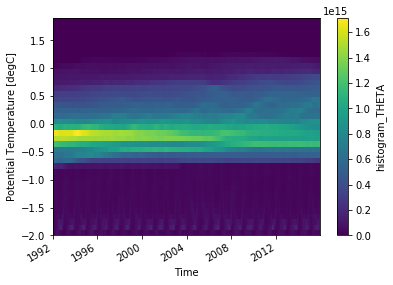

In [15]:
# most of the WG is ~0˚C
theta_dist.plot(x='time')

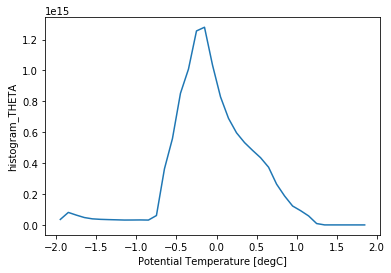

In [16]:
# most of the WG is freezing (centered ~0˚C)
theta_dist.mean(dim='time').plot()

(-2, 2)

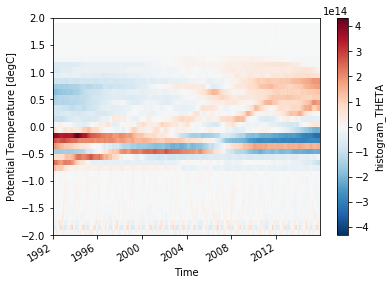

In [17]:
# theta distribution anomaly
(theta_dist - theta_dist.mean(dim='time')).plot(x='time')
plt.ylim([-2, 2])

# $\frac{\partial \mathcal{V}}{\partial t}$

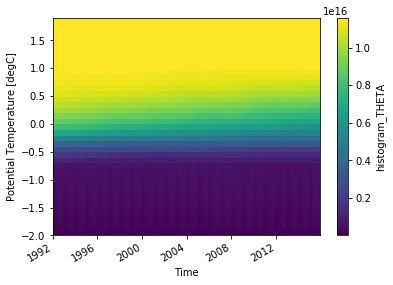

In [11]:
# cumulative volume
V = theta_dist.cumsum(dim='THETA_bin')
V.transpose().plot()

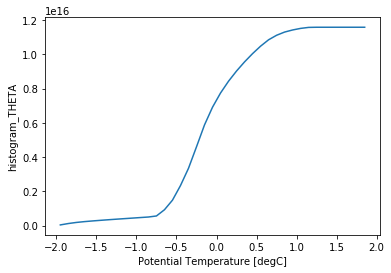

In [12]:
#time avg of cumulative volume
V_mean = V.mean(dim='time')
V_mean.plot()

(-2, 2)

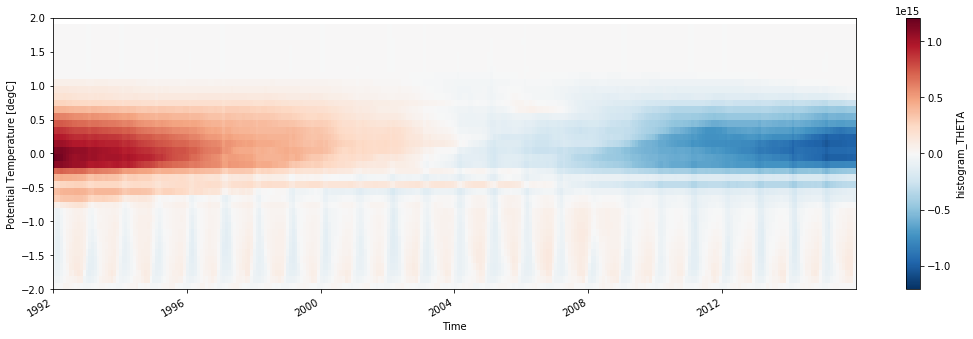

In [13]:
#cumulative volume anomaly
V_anom = V - V_mean
V_anom.plot(x='time', figsize=(18, 5))
plt.ylim(-2,2)

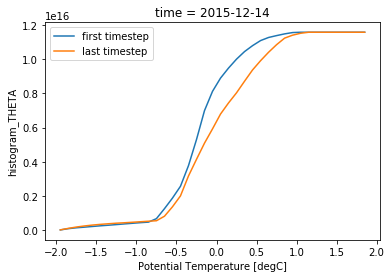

In [14]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()

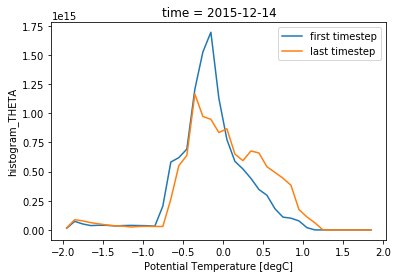

In [15]:
theta_dist[0].plot(label='first timestep')
theta_dist[-1].plot(label='last timestep')
plt.legend()

(-2, 2)

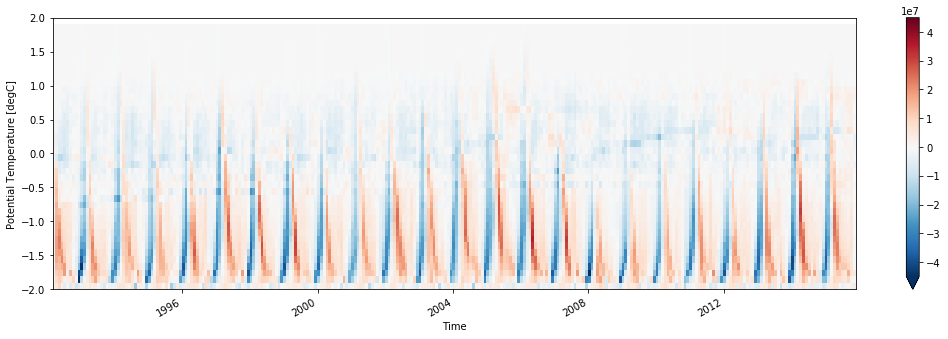

In [16]:
#using V_anom bc there is no change in V_mean
dVdt = V_anom[1:287].diff(dim='time') / dt
dVdt.plot(x='time', vmax=45e6, figsize=(18, 5))
plt.ylim(-2, 2)

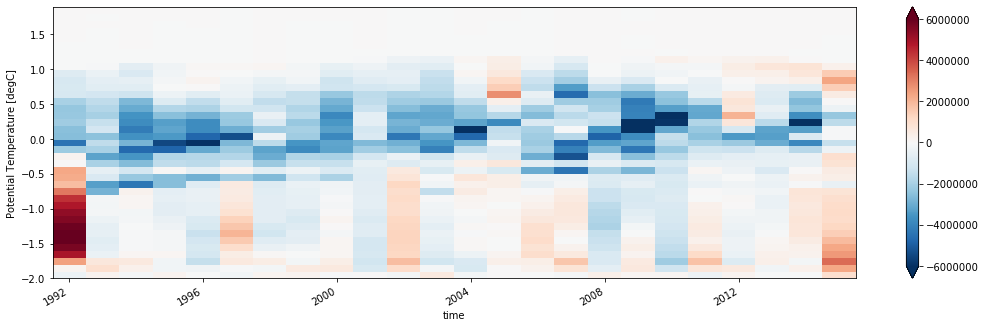

In [17]:
dVdt = V_anom[1:287].diff(dim='time') / dt
dVdt.resample(time='AS').mean().plot(x='time', vmax=6e6, figsize=(18, 5))

# $\Psi$

$$
-\int_{\delta R}  (\mathbf{u} \cdot  \hat{\mathbf{n}} ) \mathcal{H}(\tilde \theta - \theta)\ dA
$$

$$
= -\int_{\tilde\theta_{min}}^{\tilde\theta} d\tilde\theta \int_{\delta R}  (\mathbf{u} \cdot  \hat{\mathbf{n}} ) \delta(\tilde\theta - \theta)\ dA
$$

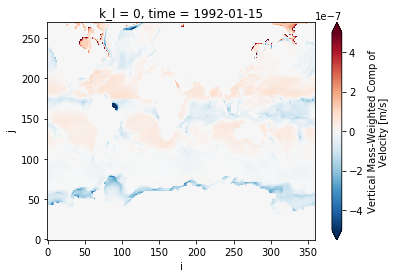

In [92]:
ds.WVELMASS[0, 0].plot(vmax=5e-7)

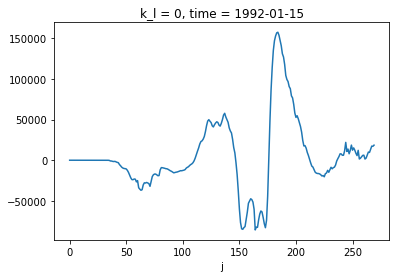

In [88]:
(ds.WVELMASS[0, 0] * coords.rA).sum(dim='i').plot()
#150 to 200 (ITCZ band) you have mass flux into the ocean

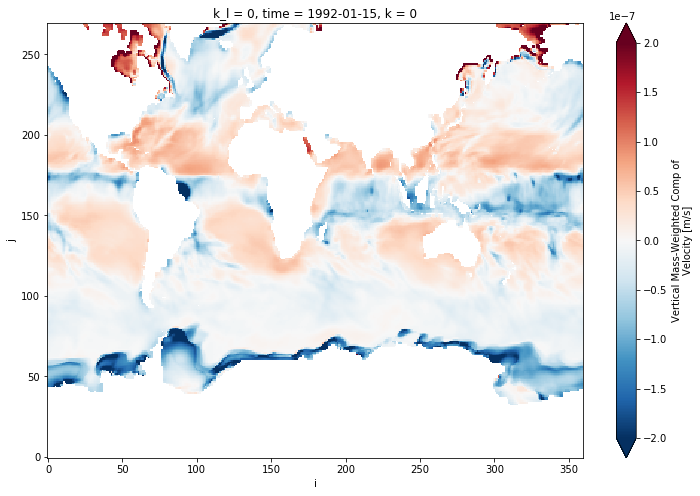

In [128]:
###### determine sign convention of vels
#ds.UVELMASS.where(coords.hFacW > 0)[0,0].plot(vmax=4e-1, figsize=(12,8))
#ds.VVELMASS.where(coords.hFacS > 0)[0,0].plot(vmax=4e-1, figsize=(12,8))
#ds.WVELMASS.where(coords.hFacC > 0)[0,0, :, :, 0].plot(vmax=2e-7, figsize=(12,8))

In [18]:
#this is the "dA" part of the equation
u_transport = ds.UVELMASS * (coords.dyG * coords.drF) #m^3/s #(-) values -> westward, (+) values -> east
v_transport = ds.VVELMASS * (coords.dxG * coords.drF) #m^3/s #(-) values -> south, (+) values -> north
w_transport = ds.WVELMASS * coords.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

In [19]:
#this is the product of vel components and normal vector part of the equation
u_transport_weddell = u_transport.isel(**lat_range, i_g=right_lon)
v_transport_weddell = v_transport.isel(**lon_range, j_g=upper_lat)
w_transport_weddell = w_transport.isel(k_l=0, **lat_range, **lon_range)

In [20]:
u_transport_mean_value = u_transport_weddell.mean(dim='time').sum().values
u_transport_mean_value

array(-20552630., dtype=float32)

In [21]:
v_transport_mean_value = v_transport_weddell.mean(dim='time').sum().values
v_transport_mean_value

array(20544304., dtype=float32)

In [22]:
w_transport_mean_value = w_transport_weddell.mean(dim='time').sum().values
w_transport_mean_value #~0.008Sv vertical massflux out of the ocean.

array(8592.014, dtype=float32)

In [24]:
#residual potentially due to E-R-P
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual #~23Sv leaving to the region

266.01367

In [25]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'i', 'left': 'i_g'}, 
                             'Y': {'center': 'j', 'left': 'j_g'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'k', 'left': 'k_l', 'outer': 'k_p1', 'right': 'k_u'}},
                             periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic):
  * center   time
Z Axis (not periodic):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center

In [26]:
#interpolating theta to be on same grid pt as velocity components
theta_at_u = grid.interp(ds.THETA, 'X')
theta_at_v = grid.interp(ds.THETA, 'Y', boundary='extend') #a limited form of Dirichlet boundary condition
theta_at_w = grid.interp(ds.THETA, 'Z', boundary='extend')

In [37]:
theta_at_w

<xarray.DataArray 'mul-4da1b13c221ae2779a81011d1eb1fd21' (time: 288, k_l: 50, j: 270, i: 360)>
dask.array<mul, shape=(288, 50, 270, 360), dtype=float32, chunksize=(1, 49, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i

In [27]:
theta_uvel = theta_at_u.isel(**lat_range, i_g=right_lon)
theta_vvel = theta_at_v.isel(**lon_range, j_g=upper_lat)
theta_wvel = theta_at_w.isel(k_l=0, **lat_range, **lon_range)

In [28]:
theta_vvel.coords['Z'] = coords.Z.load()
theta_uvel.coords['Z'] = coords.Z.load()
#theta_wvel.coords['Zl'] = coords.Zl.load()

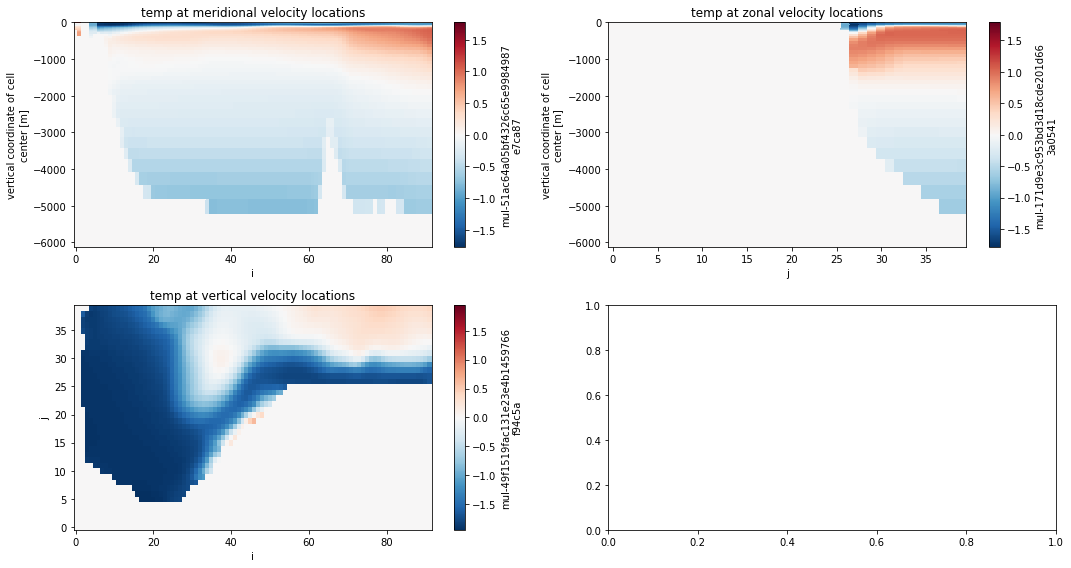

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))

theta_vvel[0].plot(y='Z', ax=ax[0,0])
#temperature values at vvel values in WG region in timestep:0
ax[0,0].title.set_text('temp at meridional velocity locations')

theta_uvel[0].plot(y='Z', ax=ax[0,1])
#temperature values at uvel values in WG region in timestep:0
ax[0,1].title.set_text('temp at zonal velocity locations')

theta_wvel[0].plot(ax=ax[1,0])
#temperature values at uvel values in WG region in timestep:0
ax[1,0].title.set_text('temp at vertical velocity locations')

plt.tight_layout();

* left panel: peninsula on the left - coldest water near surface, sandwiched in between two warm tongues (CDW?). Why is the surface water colder than the bottom? White at the bottom is bathymetry?
* continental shelf is thick. Same water tongues but from side view of right longitude.
* Bottom left: downwelling (bottom wwater formation) along the coast, upwelling near the coast (NADW->CDW->WDW)

In [30]:
uvel = ds.UVELMASS.isel(**lat_range, i_g=right_lon)
vvel = ds.VVELMASS.isel(**lon_range, j_g=upper_lat)
wvel = ds.WVELMASS.isel(k_l=0, **lat_range, **lon_range)

/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecatio

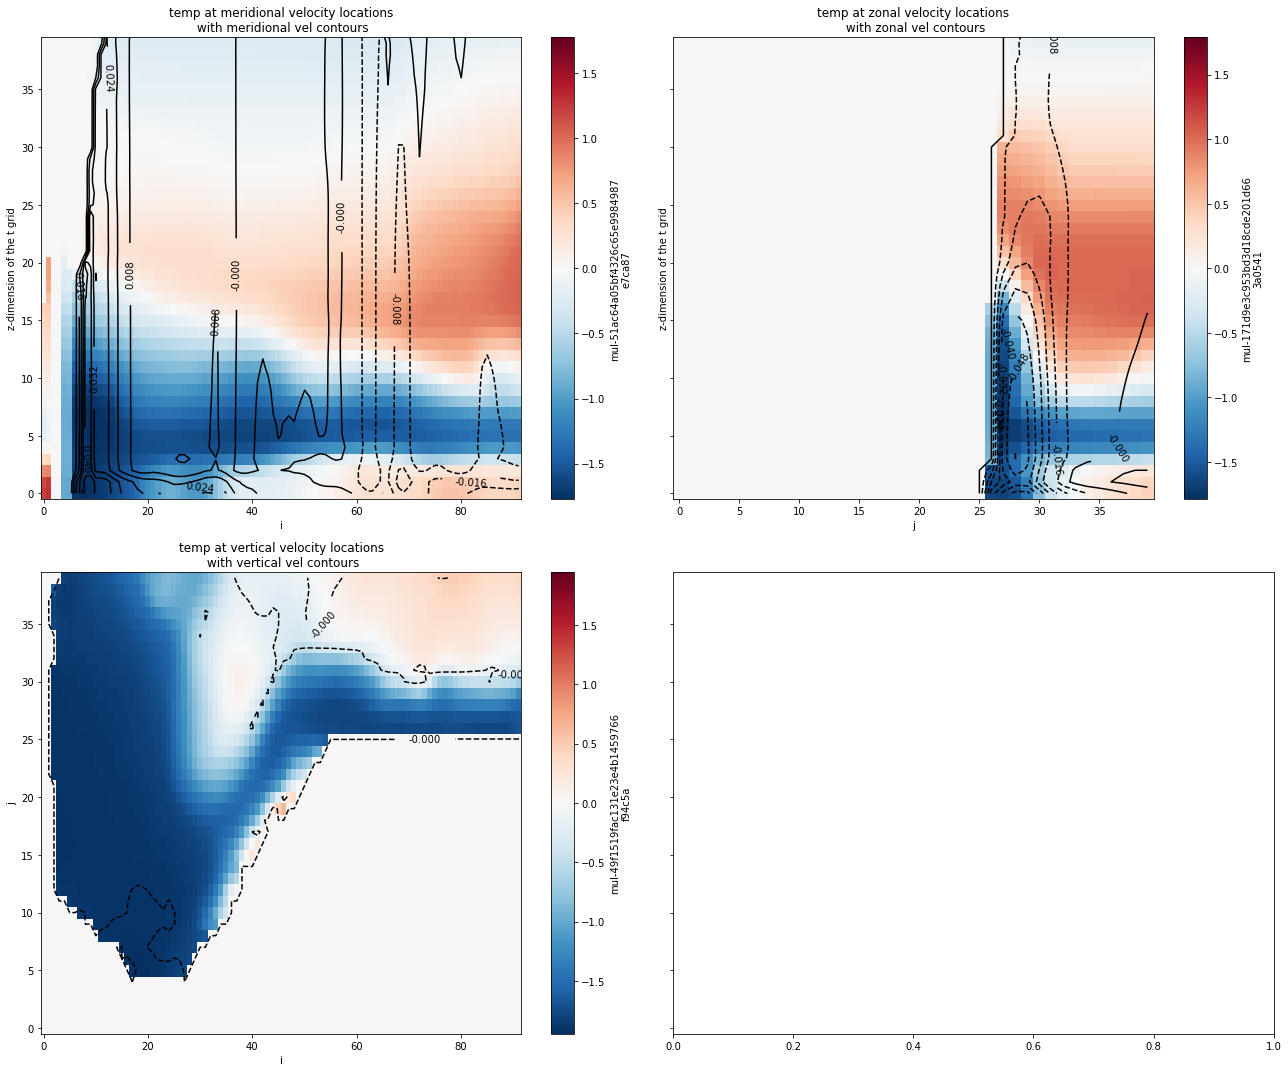

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(18,15), sharey=True)

theta_vvel[0].plot(ax=ax[0,0], yincrease=False)
cs1 = vvel[0].plot.contour(ax=ax[0,0], yincrease=False, colors='k', levels=np.arange(-0.08, 0.08, 0.008))
plt.clabel(cs1)
ax[0,0].title.set_text('temp at meridional velocity locations\n with meridional vel contours')

theta_uvel[0].plot(ax=ax[0,1], yincrease=False)
cs2 = uvel[0].plot.contour(ax=ax[0,1], yincrease=False, colors='k', levels=np.arange(-0.08, 0.08, 0.008))
plt.clabel(cs2)
ax[0,1].title.set_text('temp at zonal velocity locations\n with zonal vel contours')

theta_wvel[0].plot(ax=ax[1,0])
cs3 = wvel[0].plot.contour(ax=ax[1,0], colors='k', levels=np.arange(-0.08, 0.08, 0.008))
plt.clabel(cs3)
ax[1,0].title.set_text('temp at vertical velocity locations\n with vertical vel contours')

plt.tight_layout();

* Left Panel: Faster currents by peninsula at - 0.04(m/s?) so flowing out of the page. and velocity decreases as you move east. Warm surface water also moving out of the page (south) but at -0.020(m/s?). center contour of 0 indicates the center of WG is not moving as fast as outer layers
* Right Panel: looking from right longitude boundary. The same cold water tongue is also moving (with same vel -0.04) westward. Looks all contour levels indicate entire column moving westward (into the pg)

### Volume Budget
$$
\frac{dV}{dt} = F_{\mathcal V}^{surf} + F_{\mathcal V}^{side}
$$

In [32]:
dVol_dt = (ds.ETAN.diff(dim='time') * coords.rA) / (ds.time.diff(dim='time').astype('f')/1e9)
dVol_dt

<xarray.DataArray (time: 287, j: 270, i: 360)>
dask.array<truediv, shape=(287, 270, 360), dtype=float32, chunksize=(1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-12-14
Dimensions without coordinates: j, i

In [33]:
lhs = dVol_dt.isel(**lat_range, **lon_range).sum(dim=['i', 'j']).load()
rhs = u_transport_weddell.sum(dim=['k', 'j']) + v_transport_weddell.sum(dim=['k', 'i']) - w_transport_weddell.sum(dim=['i', 'j'])

In [34]:
rhs = rhs[1:288].load()

In [36]:
vol_budget_valid = (rhs[1:288] - lhs)

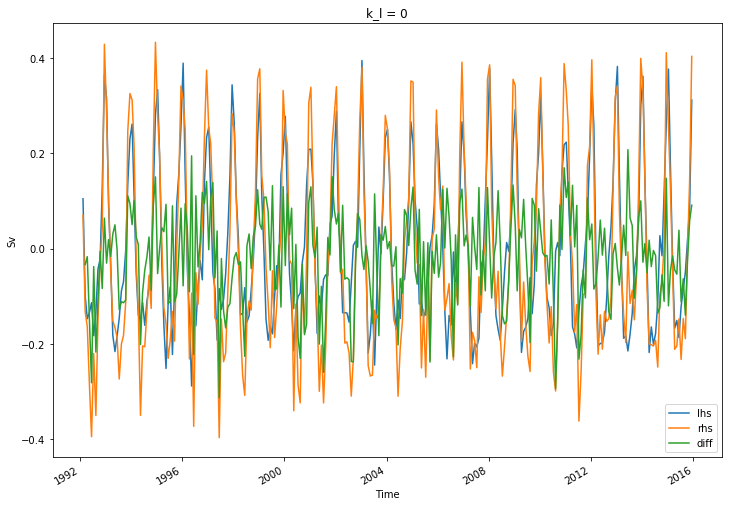

In [37]:
plt.figure(figsize=(12,8))
(lhs/1e6).plot(label='lhs')
(rhs/1e6).plot(label='rhs')
(vol_budget_valid/1e6).plot(label='diff')
plt.ylabel('Sv')
plt.legend();

### Volume Budget validated

In [41]:
#this is the delta function part of the equation above
u_binned = histogram(theta_uvel.rename('theta'), bins=[theta_bins],
                     weights=u_transport_weddell, dim=['k', 'j']).load()
v_binned = histogram(theta_vvel.rename('theta'), bins=[theta_bins],
                     weights=v_transport_weddell, dim=['k', 'i']).load()
w_binned = histogram(theta_wvel.rename('theta'), bins=[theta_bins],
                     weights=w_transport_weddell, dim=['i', 'j']).load()

In [42]:
w_binned

<xarray.DataArray 'histogram_theta' (time: 288, theta_bin: 39)>
array([[-10351.30119456, -40884.78952175, -38932.56132555, ...,
             0.        ,      0.        ,      0.        ],
       [  3893.5669469 ,  -8033.98347529, -11289.33213735, ...,
             0.        ,      0.        ,      0.        ],
       [ 63054.81952989,  16976.53012514,  14441.42338163, ...,
             0.        ,      0.        ,      0.        ],
       ...,
       [ 13051.28296947,  14564.21956668, -22568.72852257, ...,
             0.        ,      0.        ,      0.        ],
       [  -407.17372837, -65342.36525192, -71098.2667923 , ...,
             0.        ,      0.        ,      0.        ],
       [ -7083.49684906, -71137.66086388, -67087.68130493, ...,
             0.        ,      0.        ,      0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 1.65 1.75 1.85

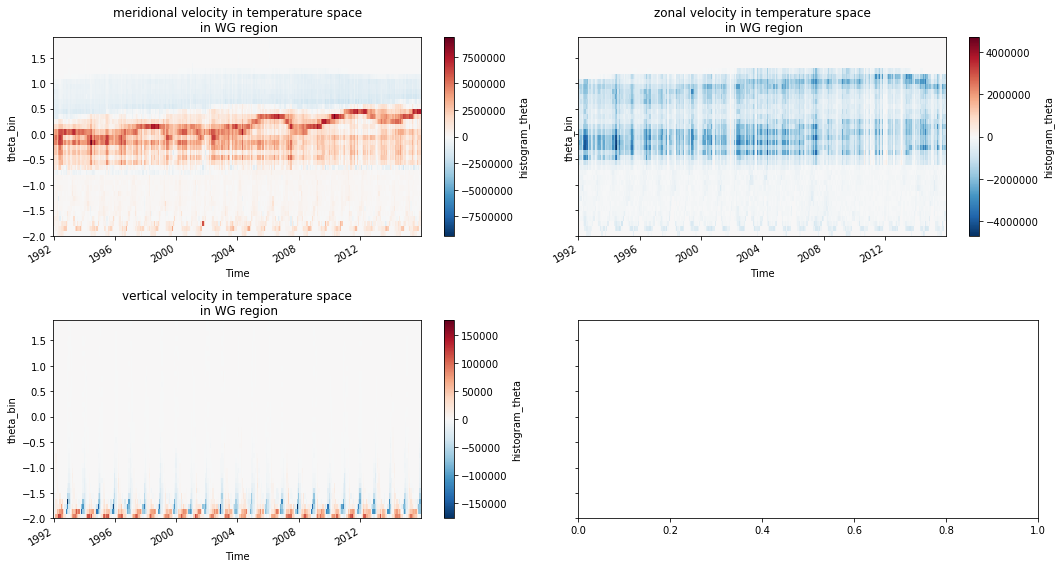

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(15,8), sharey=True)

v_binned.transpose().plot(ax=ax[0,0])
ax[0,0].title.set_text('meridional velocity in temperature space\n in WG region')

u_binned.transpose().plot(ax=ax[0,1])
ax[0,1].title.set_text('zonal velocity in temperature space\n in WG region')

w_binned.transpose().plot(ax=ax[1,0])
ax[1,0].title.set_text('vertical velocity in temperature space\n in WG region')

plt.tight_layout();

* Left Panel: Waters around 0˚C moving the fastest ~6Sv (in northward direction). Warmers waters (-0.5˚C to 1.3˚C) moving towards Antarctic coast (CDW?) ~2Sv
* Right Panel: bands of (-0.5˚C to 0˚C, and 0.5˚C to 1.3˚C) moving westward at a rate of ~3Sv (with the lower band moving slight faster than upper band)

In [45]:
transport_binned = (u_binned + v_binned + w_binned)

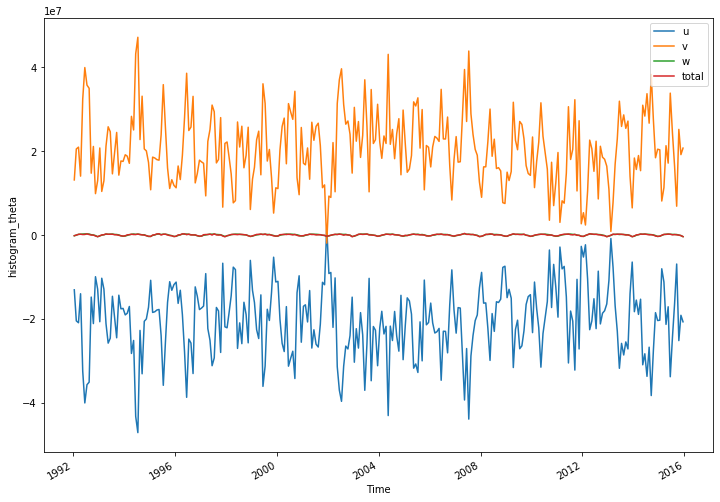

In [48]:
plt.figure(figsize=(12,8))
u_binned.sum(dim='theta_bin').plot(label='u')
v_binned.sum(dim='theta_bin').plot(label='v')
w_binned.sum(dim='theta_bin').plot(label='w')
transport_binned.sum(dim='theta_bin').plot(label='total')
plt.legend()

In [49]:
transport_binned.sum(dim='theta_bin').mean()

<xarray.DataArray 'histogram_theta' ()>
array(-36.27129742)

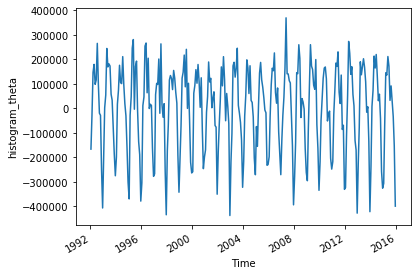

In [50]:
transport_binned.sum(dim='theta_bin').plot()

In [37]:
transport_binned.max()

<xarray.DataArray 'histogram_theta' ()>
array(6464341.69987488)

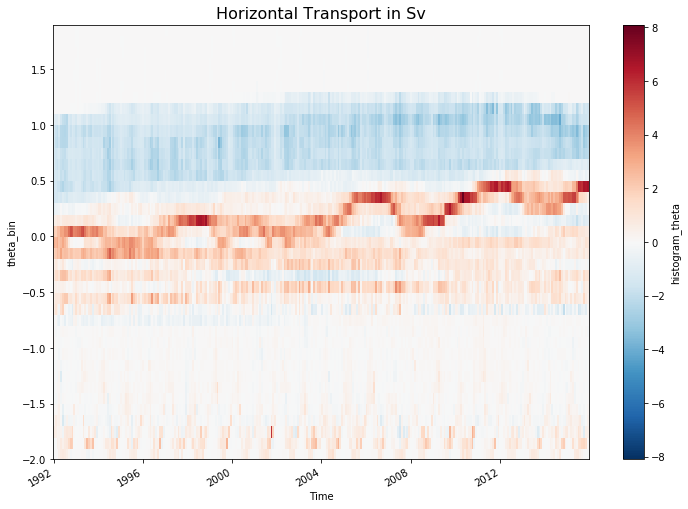

In [53]:
(transport_binned/1e6).transpose().plot(figsize=(12,8))
plt.title('Horizontal Transport in Sv', fontsize=16);

Water profiles between 0.4˚C to 1.3˚C seem to be leaving the WG region

In [54]:
#this is the theta integral part of the equation
transport_weddell = - transport_binned.cumsum(dim='theta_bin')
transport_weddell

<xarray.DataArray 'histogram_theta' (time: 288, theta_bin: 39)>
array([[ 1.03513012e+04,  5.12360907e+04, -6.06327042e+05, ...,
         1.66754778e+05,  1.66754778e+05,  1.66754778e+05],
       [-3.89356695e+03,  4.14041653e+03, -5.19147805e+05, ...,
         3.10238935e+04,  3.10238935e+04,  3.10238935e+04],
       [-6.30548195e+04, -5.14128280e+05, -7.84978642e+05, ...,
        -1.46748389e+05, -1.46748389e+05, -1.46748389e+05],
       ...,
       [-1.30512830e+04, -1.74042178e+06, -7.54321237e+05, ...,
         3.35203176e+04,  3.35203176e+04,  3.35203176e+04],
       [ 4.07173728e+02, -1.42765361e+06, -1.88907382e+06, ...,
         1.53119809e+05,  1.53119809e+05,  1.53119809e+05],
       [ 7.08349685e+03, -1.07853599e+04, -4.65231279e+05, ...,
         3.99807620e+05,  3.99807620e+05,  3.99807620e+05]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 1.65 1.75 1.85

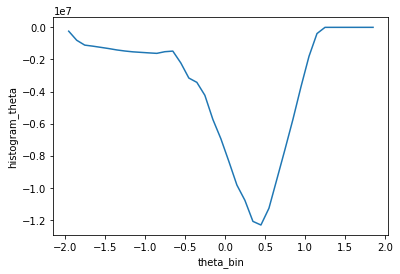

In [55]:
transport_weddell.mean(dim='time').plot()

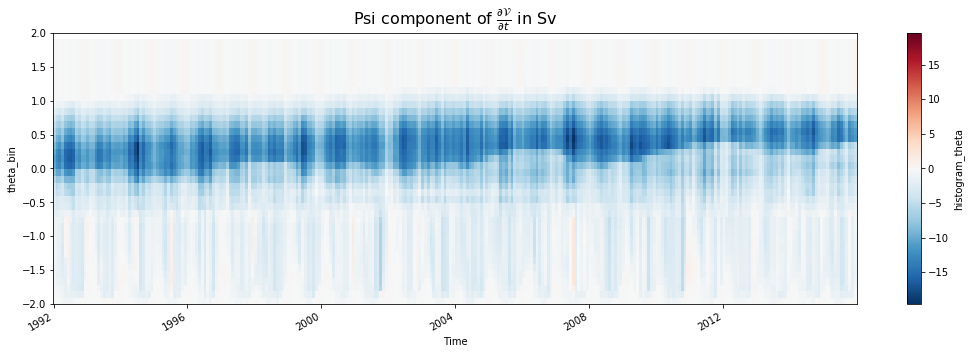

In [56]:
(transport_weddell/1e6).transpose().plot(figsize=(18, 5))
plt.ylim(-2,2)
plt.title(r'Psi component of $\frac{\partial\mathcal{V}}{\partial t}$ in Sv', fontsize=16);

In [59]:
dVdt.resample(time='AS')

DataArrayResample, grouped over '__resample_dim__' 
24 groups with labels 1992-01-01, ..., 2015-01-01.

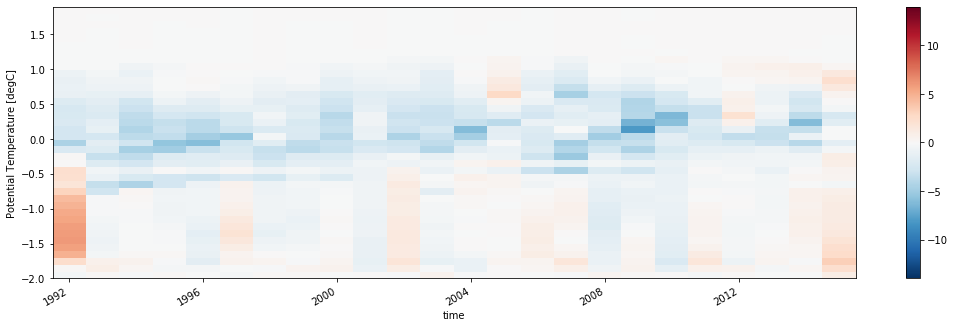

In [57]:
dVdt = V_anom[1:287].diff(dim='time') / dt
((dVdt.resample(time='AS')).mean()/1e6).plot(x='time', vmax=14, figsize=(18, 5))

Red means coming into the region and blue means leaving...right?

# $\Omega$

$$
-\int_R \delta(\tilde \theta - \theta) \dot \theta dV
$$

In [42]:
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/budget_th.zarr'))
ds_tmp

<xarray.Dataset>
Dimensions:                  (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    surface_flux_conv_TH     (k, time, j, i) float32 dask.array<chunksize=(50, 1, 270, 360), meta=np.ndarray>
    sw_flux_conv_TH          (time, j, i, k) float32 dask.array<chunksize=(1, 270, 360, 50), meta=np.ndarray>
    theta                    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>

In [43]:
ds_tmp_wg = ds_tmp.isel(**lat_range, **lon_range)
ds_tmp_wg

<xarray.Dataset>
Dimensions:                  (i: 92, j: 40, k: 50, time: 288)
Coordinates:
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    surface_flux_conv_TH     (k, time, j, i) float32 dask.array<chunksize=(50, 1, 40, 92), meta=np.ndarray>
    sw_flux_conv_TH          (time, j, i, k) float32 dask.array<chunksize=(1, 40, 92, 50), meta=np.ndarray>
    theta                    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>

In [44]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(ds_tmp_wg.theta.rename('theta'), bins=[theta_bins],
              weights=variable, dim=['i', 'j', 'k'])
    return hist

In [45]:
#this is the delta function part of the equation
fluxes = [ds_tmp_wg.conv_horiz_diff_flux_TH,
          ds_tmp_wg.conv_vert_adv_flux_TH,
          ds_tmp_wg.conv_vert_diff_flux_TH]

fluxes_binned = histogram_func(ds_tmp_wg.conv_horiz_adv_flux_TH).to_dataset(name='conv_horiz_adv_flux_TH')

for var in fluxes:
    new_vars = histogram_func(var).rename(var.name)
    fluxes_binned = xr.merge([fluxes_binned, new_vars], compat='override')

In [46]:
fluxes_binned.load()

<xarray.Dataset>
Dimensions:                  (theta_bin: 219, time: 288)
Coordinates:
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * theta_bin                (theta_bin) float64 -1.95 -1.85 ... 19.75 19.85
Data variables:
    conv_horiz_adv_flux_TH   (time, theta_bin) float64 -7.294e+05 ... 0.0
    conv_horiz_diff_flux_TH  (time, theta_bin) float64 1.455e+05 ... 0.0
    conv_vert_adv_flux_TH    (time, theta_bin) float64 7.493e+05 ... 0.0
    conv_vert_diff_flux_TH   (time, theta_bin) float64 1.367e+05 ... 0.0

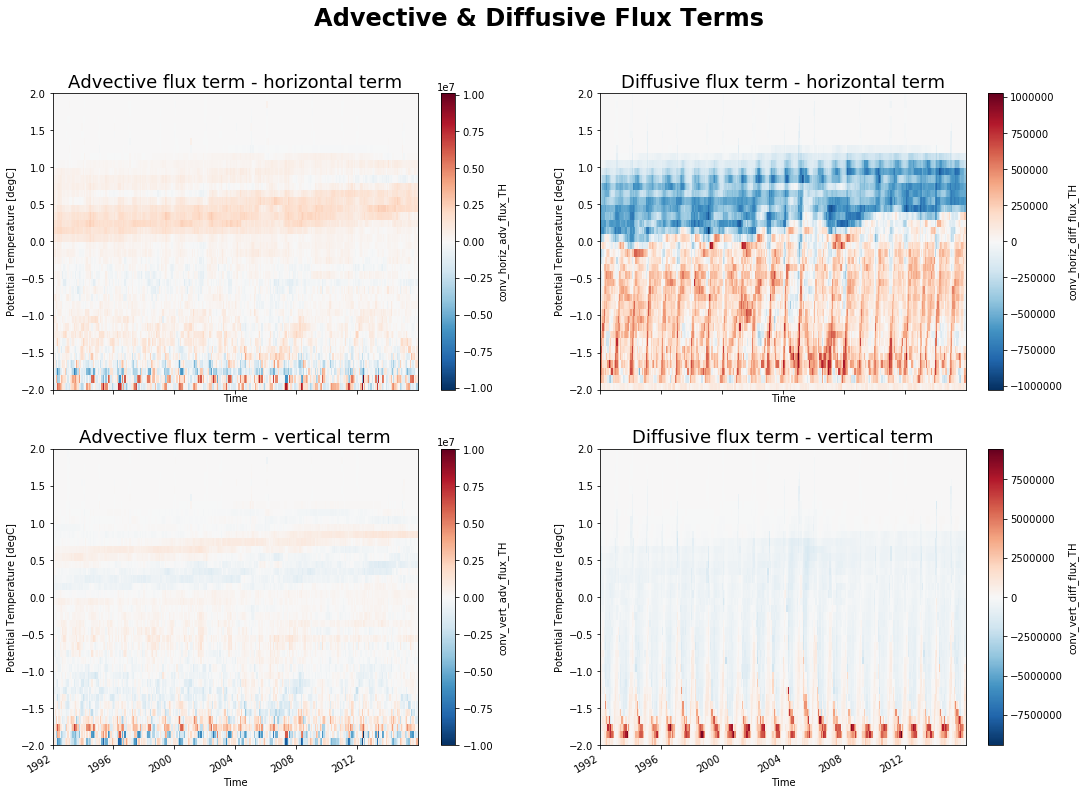

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(18,12), sharex=True)

fluxes_binned.conv_horiz_adv_flux_TH.transpose().plot(ax=axes[0,0])
axes[0,0].set_title('Advective flux term - horizontal term', fontsize=18)
axes[0,0].set_ylim(-2,2)

fluxes_binned.conv_horiz_diff_flux_TH.transpose().plot(ax=axes[0,1])
axes[0,1].set_title('Diffusive flux term - horizontal term', fontsize=18)
axes[0,1].set_ylim(-2,2)

fluxes_binned.conv_vert_adv_flux_TH.transpose().plot(ax=axes[1,0])
axes[1,0].set_title('Advective flux term - vertical term', fontsize=18)
axes[1,0].set_ylim(-2,2)

fluxes_binned.conv_vert_diff_flux_TH.transpose().plot(ax=axes[1,1])
axes[1,1].set_title('Diffusive flux term - vertical term', fontsize=18)
axes[1,1].set_ylim(-2,2)

plt.suptitle('Advective & Diffusive Flux Terms', weight='bold', fontsize=24);

### Surface terms

In [48]:
ds_tmp_wg.surface_flux_conv_TH

<xarray.DataArray 'surface_flux_conv_TH' (k: 50, time: 288, j: 40, i: 92)>
dask.array<getitem, shape=(50, 288, 40, 92), dtype=float32, chunksize=(50, 1, 40, 92), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

In [49]:
#delta part of the equation
sw_binned = histogram_func(ds_tmp_wg.sw_flux_conv_TH).load()
surf_binned = histogram(ds_tmp_wg.theta.isel(k=0).rename('theta'), bins=[theta_bins],
                        weights=ds_tmp_wg.surface_flux_conv_TH, dim=['i', 'j', 'k']).load()
#have to do manual xhistogram function on surface_flux term bc have to specify top level only

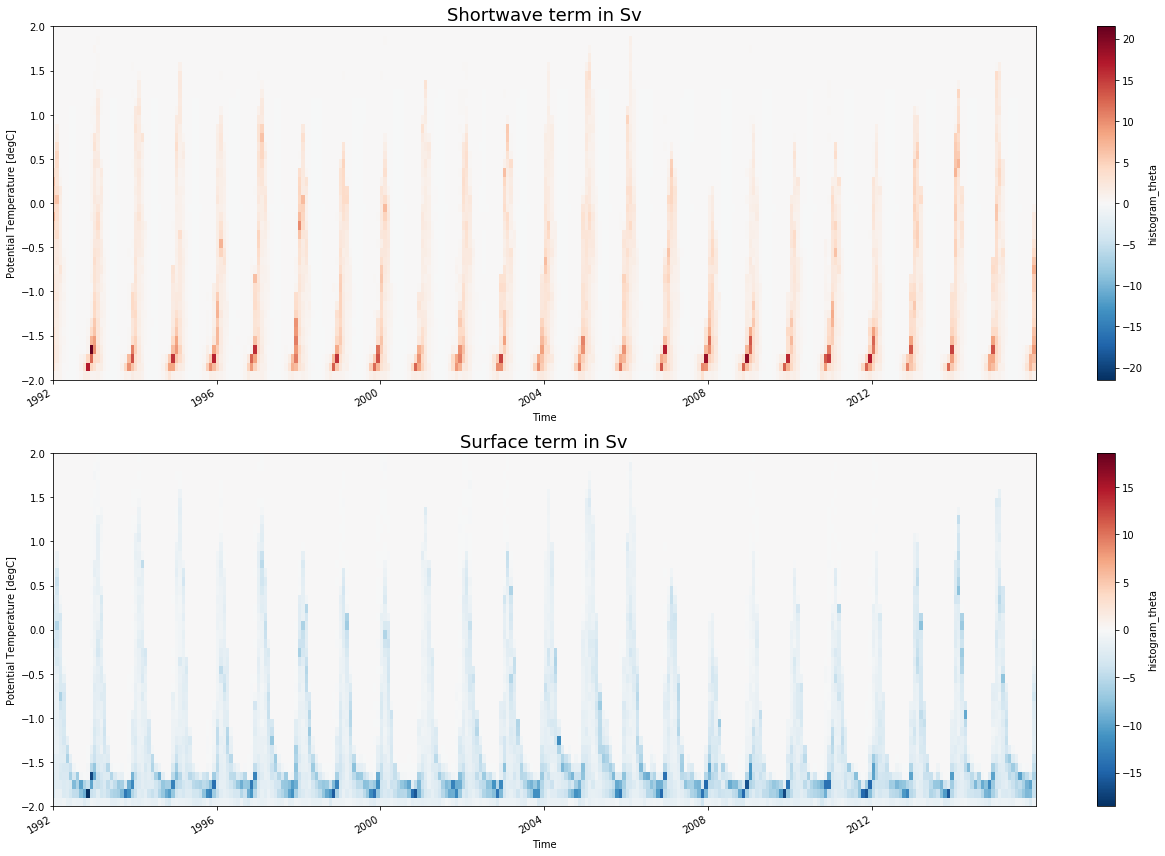

In [50]:
fig, axes = plt.subplots(2, figsize=(18,12))

(sw_binned/1e6).transpose().plot(ax=axes[0])
axes[0].set_title('Shortwave term in Sv', fontsize=18)
axes[0].set_ylim(-2,2)

(surf_binned/1e6).transpose().plot(ax=axes[1])
axes[1].set_title('Surface term in Sv', fontsize=18)
axes[1].set_ylim(-2,2)

plt.tight_layout();

In [51]:
omega = - (fluxes_binned.conv_horiz_diff_flux_TH + 
           fluxes_binned.conv_vert_diff_flux_TH +
           sw_binned + 
           surf_binned)
omega

<xarray.DataArray (time: 288, theta_bin: 219)>
array([[  -51021.29802525,  -697613.07512936, -1413207.11007553, ...,
              -0.        ,       -0.        ,       -0.        ],
       [  240994.56659079,   -64835.43326353,  -427149.57178923, ...,
              -0.        ,       -0.        ,       -0.        ],
       [   16363.10441488,   328979.67679701,   420153.43290829, ...,
              -0.        ,       -0.        ,       -0.        ],
       ...,
       [   80609.81500794,  1178508.54445686,  1835011.96872017, ...,
              -0.        ,       -0.        ,       -0.        ],
       [ -252662.27114782, -1147962.28370129, -1046590.61274254, ...,
              -0.        ,       -0.        ,       -0.        ],
       [  -83054.87179144, -1364274.5263872 , -3200316.26059661, ...,
              -0.        ,       -0.        ,       -0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 19.65 19.75 19.85

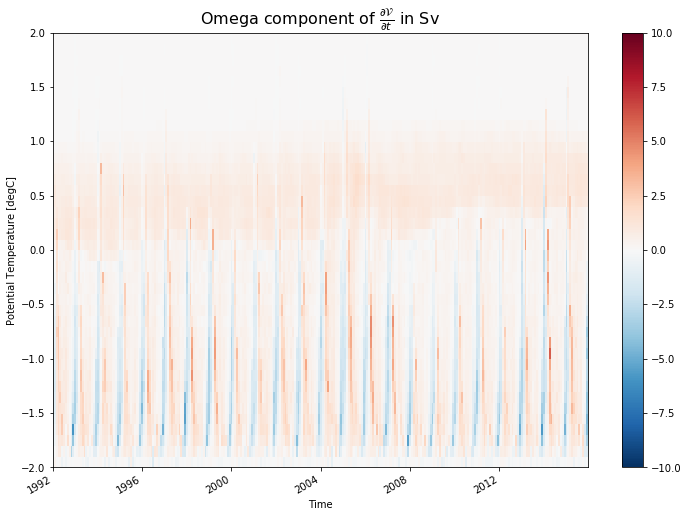

In [52]:
(omega/1e6).transpose().plot(figsize=(12,8), vmax=10 )
plt.ylim(-2,2)
plt.title(r'Omega component of $\frac{\partial\mathcal{V}}{\partial t}$ in Sv', fontsize=16);

In [ ]:
((dVdt.resample(time='AS')).mean()/1e6).plot(x='time', vmax=14, figsize=(18, 5))
plt.ylim(-2, 2)

plt.figure()


### $\Psi + \Omega$

In [53]:
tendency_term = (transport_weddell + omega)
tendency_term

<xarray.DataArray (time: 288, theta_bin: 219)>
array([[  -51021.29802525,  -697613.07512936, -2085501.58077866, ...,
         4135106.97118145,  4135106.97118145,  4135106.97118145],
       [  240994.56659079,   -64835.43326353,  -961727.12550016, ...,
         4263881.47117329,  4263881.47117329,  4263881.47117329],
       [   16363.10441488,   -89263.55171862,  -253136.38935733, ...,
         4823072.15666962,  4823072.15666962,  4823072.15666962],
       ...,
       [   80609.81500794,  -502853.85465202,  1123741.81809781, ...,
         5110061.94294155,  5110061.94294155,  5110061.94294155],
       [ -252662.27114782, -2636515.72144543, -3027191.64117729, ...,
         4981053.70744181,  4981053.70744181,  4981053.70744181],
       [  -83054.87179144, -1453281.04396533, -3805026.56992278, ...,
         5160184.20014524,  5160184.20014524,  5160184.20014524]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 19.65 19.75 19.85

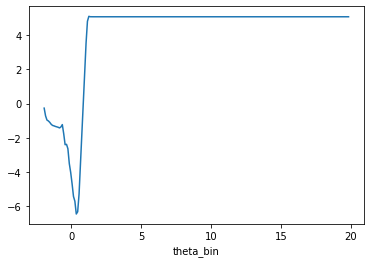

In [54]:
#time_avg to get right of lhs
tendency_term_mean = tendency_term.mean(dim='time')
(tendency_term_mean/1e6).plot()

### $\frac{\int \frac{\partial \mathcal{V}}{\partial t}\ dt}{t - t_0}$

In [55]:
dVdt_time_mean = dVdt.mean(dim='time')
dVdt_time_mean

<xarray.DataArray (THETA_bin: 219)>
array([ 6.32172747e+04,  1.81546769e+05,  2.42993441e+05,  2.41174073e+05,
        2.06156391e+05,  1.75255069e+05,  1.54614506e+05,  1.32426037e+05,
        1.08784461e+05,  9.51689599e+04,  7.83465948e+04,  6.57996691e+04,
       -1.60730141e+05, -5.83328602e+05, -6.92962796e+05, -7.66632343e+05,
       -8.22710722e+05, -1.56112599e+06, -2.53892277e+06, -2.92802869e+06,
       -2.80975466e+06, -2.73103399e+06, -2.63147455e+06, -2.32456218e+06,
       -1.90945276e+06, -1.58533077e+06, -1.16739591e+06, -7.25556957e+05,
       -3.45641133e+05, -2.12567902e+05, -8.70051097e+04, -5.14581778e+03,
       -3.95320978e+03, -2.58708104e+03, -1.50016035e+03, -7.12418395e+02,
       -3.61620140e+02, -1.75350337e+02, -6.79393487e+00,  6.36542822e+01,
        3.92541403e+01,  4.34787781e+01,  5.06924648e+01,  6.16603000e+01,
        4.70368983e+01,  1.57008448e+01,  1.18253173e+01, -1.57968202e+01,
       -2.22419550e+01, -1.56176351e+01, -6.62717266e+00,  6.17537996e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.000

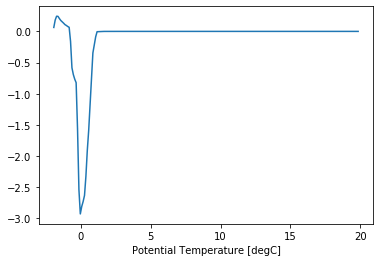

In [56]:
(dVdt_time_mean/1e6).plot()

### $\frac{\int \frac{\partial \mathcal{V}}{\partial t}\ dt}{t - t_0} = \bar{\Psi} + \bar{\Omega}$

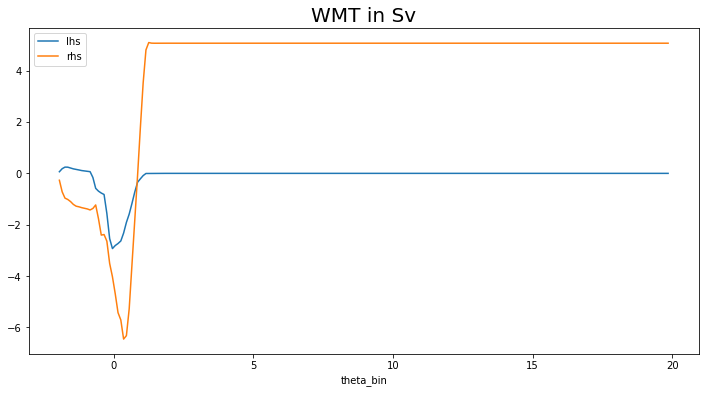

In [57]:
plt.figure(figsize=(12,6))
(dVdt_time_mean/1e6).plot(label='lhs')
(tendency_term_mean/1e6).plot(label='rhs')
plt.legend()
plt.title('WMT in Sv', fontsize=20);

### NTS:

$$
\frac{\int \frac{\partial \mathcal{V}}{\partial t}\ dt}{t - t_0} = \bar{\Psi} + \bar{\Omega}
$$